### Plot replay by session

In [41]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.common.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,classify_ripples,classify_ripple_content,
                                   get_df_tally,find_tally_df)

In [82]:
nwb_file_names=['molly20220415.nwb','molly20220416.nwb','molly20220417.nwb','molly20220418.nwb','molly20220419.nwb','molly20220420.nwb']

In [83]:
H=[]
H_boot_mean=[]
H_boot_CI_l=[]
H_boot_CI_u=[]

O=[]
O_boot_mean=[]
O_boot_CI_l=[]
O_boot_CI_u=[]

session_name=[]

for nwb_file_name in nwb_file_names:
    nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)
    decoding_path=(Decode &
               {'nwb_file_name': nwb_copy_file_name}).fetch('posterior')[0]
    animal=nwb_file_name[:5]
    date=nwb_copy_file_name[5:-5]
    resultfolder=os.path.join(os.path.split(decoding_path)[0],'analysis')
    
    data=pickle.load(open(os.path.join(resultfolder,
                              'replay_category_'+animal+'_'+date+'_epoch.p'),"rb"))
    
    epoch_day=list(data.keys())
    for e in epoch_day:
        session_name.append(date+'epoch_'+str(e))
        H.append(data[e]['categories_H_day_prop'])
        H_boot_mean.append(data[e]['H_boot_mean'])
        H_boot_CI_l.append(data[e]['H_boot_CI'][0])
        H_boot_CI_u.append(data[e]['H_boot_CI'][1])

        O.append(data[e]['categories_O_day_prop'])
        O_boot_mean.append(data[e]['O_boot_mean'])
        O_boot_CI_l.append(data[e]['O_boot_CI'][0])
        O_boot_CI_u.append(data[e]['O_boot_CI'][1])
H_boot_mean=np.array(H_boot_mean)
H_boot_CI_l=np.array(H_boot_CI_l)
H_boot_CI_u=np.array(H_boot_CI_u)

O_boot_mean=np.array(O_boot_mean)
O_boot_CI_l=np.array(O_boot_CI_l)
O_boot_CI_u=np.array(O_boot_CI_u)

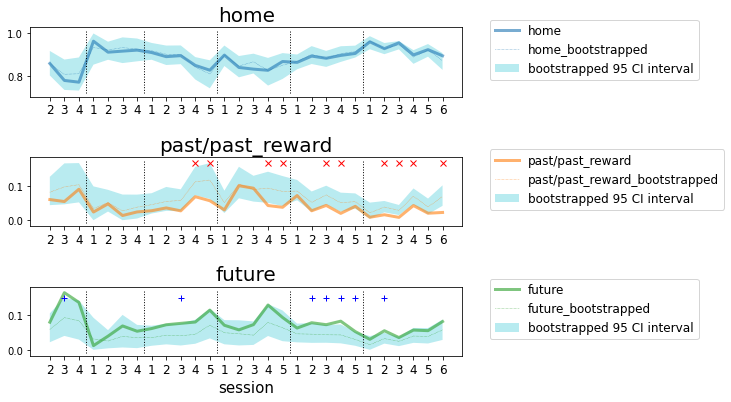

In [84]:
category_names_H=list(H[0].keys())

fig,axes=plt.subplots(len(category_names_H),1,figsize=(12, 12))

# plot result
for c in range(len(category_names_H)):
    data_result=[H[d][category_names_H[c]] for d in range(len(H))]
    axes[c].plot(data_result,linewidth=3,color='C'+str(c),label=category_names_H[c],alpha=0.6)
    axes[c].plot(H_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_H[c]+'_bootstrapped',linestyle=':')
    axes[c].fill_between(np.arange(len(H)),
                         H_boot_CI_u[:,c],H_boot_CI_l[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind_more=np.argwhere(data_result>(H_boot_CI_u[:,c]))
    significant_ind_less=np.argwhere(data_result<(H_boot_CI_l[:,c]))
    #significant_ind=np.argwhere(np.logical_or(
    #    mean_data[:,c]>(std_up_random[:,c]),
    #    mean_data[:,c]<(std_down_random[:,c]))
    axes[c].plot(significant_ind_more,np.ones_like(significant_ind_more)*np.max(H_boot_CI_u[:,c]),'+',color='b')
    axes[c].plot(significant_ind_less,np.ones_like(significant_ind_less)*np.max(H_boot_CI_u[:,c]),'x',color='r')
        
    axes[c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[c].set_xticks(np.arange(len(H)));
    if c==2:
        axes[c].set_xlabel('session',fontsize=15);
    epoch_within_day=[int(int(s.split('_')[1])/2) for s in session_name]
    axes[c].set_xticklabels(epoch_within_day,fontsize=12);
    axes[c].set_title(category_names_H[c],fontsize=20)
    
    #
    day=[int(s[:8]) for s in session_name]
    day_change=np.argwhere(np.diff(day)).ravel()+1
    ylim=axes[c].get_ylim()
    for t in day_change:
        axes[c].plot([t-0.5,t-0.5],ylim,'k:',linewidth=1,)
#plt.text(0.6,1.05,'Replays at HOME',fontsize=20)    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    

Text(0.6, 1.1, 'Replays at ARMs')

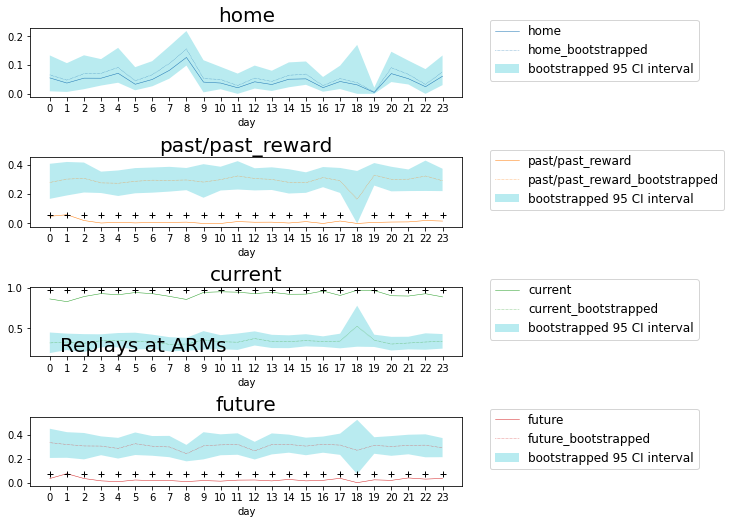

In [81]:
category_names_O=list(O[0].keys())

fig,axes=plt.subplots(len(category_names_O),1,figsize=(12, 12))

# plot result
for c in range(len(category_names_O)):
    data_result=[O[d][category_names_O[c]] for d in range(len(H))]
    axes[c].plot(data_result,linewidth=0.5,color='C'+str(c),label=category_names_O[c])
    axes[c].plot(O_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_O[c]+'_bootstrapped',linestyle=':')
    axes[c].fill_between(np.arange(len(O)),
                         O_boot_CI_u[:,c],O_boot_CI_l[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind=np.argwhere(np.logical_or(
        data_result>(O_boot_CI_u[:,c]),
        data_result<(O_boot_CI_l[:,c])))
    #significant_ind=np.argwhere(np.logical_or(
    #    mean_data[:,c]>(std_up_random[:,c]),
    #    mean_data[:,c]<(std_down_random[:,c]))
    axes[c].plot(significant_ind,np.ones_like(significant_ind)*np.max(data_result),'+',color='k')
        
    axes[c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[c].set_xticks(np.arange(len(H)));
    axes[c].set_xlabel('day');
    #axes[0].set_xticklabels(['1],fontsize=16);
    axes[c].set_title(category_names_O[c],fontsize=20)
plt.text(0.6,1.1,'Replays at ARMs',fontsize=20)    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    